# House Prices and Future Population Growth

Welcome to my data project. I will be researching the correlation between the prognosis of population growth between 2024 and 2040, and current house prices pr. sqm. The theory is, that lower prices will make an area more attractive for having children, while conversely high prices reflect a high demand for living in the area. It will therefore be interested to see which way the pendulum swings, or whether the two effects cancel eachother out:

I begin by installing the DST API, as I will be using data from Statistics Denmark. This is done following the guide closely. I begin by importing the data set FOLK1A. In addition, I import pandas:

In [1]:
#%pip install git+https://github.com/alemartinello/dstapi
import pandas as pd

# Start by importing necessary packages
import requests
import pandas as pd
from IPython.display import display
from io import StringIO

from dstapi import DstApi # The helper class

# Fetching Population Data from DST's API

In [2]:
# Directly embed parameters in the URL with response.get()
requests.get('https://api.statbank.dk/v1' + '/tableinfo' + "?id=folk1a&format=JSON").json()

# Pass a dictionary of parameters to requests.get()
params = {'id': 'folk1a', 'format': 'JSON'}
requests.get('https://api.statbank.dk/v1' + '/tableinfo', params=params).json()

# Use response.post() - note the change in the name of the parameter about the table's name
# I'm also adding here a language parameter - most tables are available in both Danish and English
params = {'table': 'folk1a', 'format': 'JSON', 'lang':'en'}
requests.post('https://api.statbank.dk/v1' + '/tableinfo', json=params).json()

{'id': 'FOLK1A',
 'text': 'Population at the first day of the quarter',
 'description': 'Population at the first day of the quarter by region, sex, age, marital status and time',
 'unit': 'Number',
 'suppressedDataValue': '0',
 'updated': '2024-02-12T08:00:00',
 'active': True,
 'contacts': [{'name': 'Dorthe Larsen',
   'phone': '39173307',
   'mail': 'dla@dst.dk'}],
 'documentation': {'id': '4a12721d-a8b0-4bde-82d7-1d1c6f319de3',
  'url': 'https://www.dst.dk/documentationofstatistics/4a12721d-a8b0-4bde-82d7-1d1c6f319de3'},
 'footnote': None,
 'variables': [{'id': 'OMRÅDE',
   'text': 'region',
   'elimination': True,
   'time': False,
   'map': 'denmark_municipality_07',
   'values': [{'id': '000', 'text': 'All Denmark'},
    {'id': '084', 'text': 'Region Hovedstaden'},
    {'id': '101', 'text': 'Copenhagen'},
    {'id': '147', 'text': 'Frederiksberg'},
    {'id': '155', 'text': 'Dragør'},
    {'id': '185', 'text': 'Tårnby'},
    {'id': '165', 'text': 'Albertslund'},
    {'id': '151',

I am now interested in further examining the table. In particular, I want population data for each kommune, but not for the aggregate regions or the entire country.

In [3]:
# Initialize the class with the target table
folk = DstApi('FOLK1A')

# Get the table summary
folk.tablesummary(language='en')

Table FOLK1A: Population at the first day of the quarter by region, sex, age, marital status and time
Last update: 2024-02-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,105,000,All Denmark,851,Aalborg,False
1,KØN,3,TOT,Total,2,Women,False
2,ALDER,127,IALT,"Age, total",125,125 years,False
3,CIVILSTAND,5,TOT,Total,F,Divorced,False
4,Tid,65,2008K1,2008Q1,2024K1,2024Q1,True


I examine the area variable, making sure my table displays all the rows:

In [4]:
pd.set_option('display.max_rows', 106)

print(folk.variable_levels('OMRÅDE', language='en').head(106))

      id                text
0    000         All Denmark
1    084  Region Hovedstaden
2    101          Copenhagen
3    147       Frederiksberg
4    155              Dragør
5    185              Tårnby
6    165         Albertslund
7    151            Ballerup
8    153             Brøndby
9    157            Gentofte
10   159            Gladsaxe
11   161            Glostrup
12   163              Herlev
13   167            Hvidovre
14   169       Høje-Taastrup
15   183               Ishøj
16   173      Lyngby-Taarbæk
17   175             Rødovre
18   187          Vallensbæk
19   201             Allerød
20   240              Egedal
21   210         Fredensborg
22   250       Frederikssund
23   190              Furesø
24   270            Gribskov
25   260             Halsnæs
26   217           Helsingør
27   219            Hillerød
28   223            Hørsholm
29   230           Rudersdal
30   400            Bornholm
31   411         Christiansø
32   085     Region Sjælland
33   253      

From here, i make a list, deleting all values under 100, as these are area codes for aggregates, and I only want data for kommuner. I also manually removed Christiansø:

In [5]:
area_dict = {
    "000": "All Denmark",
    "084": "Region Hovedstaden",
    "101": "Copenhagen",
    "147": "Frederiksberg",
    "155": "Dragør",
    "185": "Tårnby",
    "165": "Albertslund",
    "151": "Ballerup",
    "153": "Brøndby",
    "157": "Gentofte",
    "159": "Gladsaxe",
    "161": "Glostrup",
    "163": "Herlev",
    "167": "Hvidovre",
    "169": "Høje-Taastrup",
    "183": "Ishøj",
    "173": "Lyngby-Taarbæk",
    "175": "Rødovre",
    "187": "Vallensbæk",
    "201": "Allerød",
    "240": "Egedal",
    "210": "Fredensborg",
    "250": "Frederikssund",
    "190": "Furesø",
    "270": "Gribskov",
    "260": "Halsnæs",
    "217": "Helsingør",
    "219": "Hillerød",
    "223": "Hørsholm",
    "230": "Rudersdal",
    "400": "Bornholm",
    "085": "Region Sjælland",
    "253": "Greve",
    "259": "Køge",
    "350": "Lejre",
    "265": "Roskilde",
    "269": "Solrød",
    "320": "Faxe",
    "376": "Guldborgsund",
    "316": "Holbæk",
    "326": "Kalundborg",
    "360": "Lolland",
    "370": "Næstved",
    "306": "Odsherred",
    "329": "Ringsted",
    "330": "Slagelse",
    "340": "Sorø",
    "336": "Stevns",
    "390": "Vordingborg",
    "083": "Region Syddanmark",
    "420": "Assens",
    "430": "Faaborg-Midtfyn",
    "440": "Kerteminde",
    "482": "Langeland",
    "410": "Middelfart",
    "480": "Nordfyns",
    "450": "Nyborg",
    "461": "Odense",
    "479": "Svendborg",
    "492": "Ærø",
    "530": "Billund",
    "561": "Esbjerg",
    "563": "Fanø",
    "607": "Fredericia",
    "510": "Haderslev",
    "621": "Kolding",
    "540": "Sønderborg",
    "550": "Tønder",
    "573": "Varde",
    "575": "Vejen",
    "630": "Vejle",
    "580": "Aabenraa",
    "082": "Region Midtjylland",
    "710": "Favrskov",
    "766": "Hedensted",
    "615": "Horsens",
    "707": "Norddjurs",
    "727": "Odder",
    "730": "Randers",
    "741": "Samsø",
    "740": "Silkeborg",
    "746": "Skanderborg",
    "706": "Syddjurs",
    "751": "Aarhus",
    "657": "Herning",
    "661": "Holstebro",
    "756": "Ikast-Brande",
    "665": "Lemvig",
    "760": "Ringkøbing-Skjern",
    "779": "Skive",
    "671": "Struer",
    "791": "Viborg",
    "081": "Region Nordjylland",
    "810": "Brønderslev",
    "813": "Frederikshavn",
    "860": "Hjørring",
    "849": "Jammerbugt",
    "825": "Læsø",
    "846": "Mariagerfjord",
    "773": "Morsø",
    "840": "Rebild",
    "787": "Thisted",
    "820": "Vesthimmerlands",
    "851": "Aalborg"
}

# Filter out items with keys less than 100
kommuner_dict = {k: v for k, v in area_dict.items() if int(k) >= 100}

# Print the filtered dictionary
print(len(kommuner_dict))


print(kommuner_dict)




98
{'101': 'Copenhagen', '147': 'Frederiksberg', '155': 'Dragør', '185': 'Tårnby', '165': 'Albertslund', '151': 'Ballerup', '153': 'Brøndby', '157': 'Gentofte', '159': 'Gladsaxe', '161': 'Glostrup', '163': 'Herlev', '167': 'Hvidovre', '169': 'Høje-Taastrup', '183': 'Ishøj', '173': 'Lyngby-Taarbæk', '175': 'Rødovre', '187': 'Vallensbæk', '201': 'Allerød', '240': 'Egedal', '210': 'Fredensborg', '250': 'Frederikssund', '190': 'Furesø', '270': 'Gribskov', '260': 'Halsnæs', '217': 'Helsingør', '219': 'Hillerød', '223': 'Hørsholm', '230': 'Rudersdal', '400': 'Bornholm', '253': 'Greve', '259': 'Køge', '350': 'Lejre', '265': 'Roskilde', '269': 'Solrød', '320': 'Faxe', '376': 'Guldborgsund', '316': 'Holbæk', '326': 'Kalundborg', '360': 'Lolland', '370': 'Næstved', '306': 'Odsherred', '329': 'Ringsted', '330': 'Slagelse', '340': 'Sorø', '336': 'Stevns', '390': 'Vordingborg', '420': 'Assens', '430': 'Faaborg-Midtfyn', '440': 'Kerteminde', '482': 'Langeland', '410': 'Middelfart', '480': 'Nordfyns'

As seen, the dictionary gives 98 kommuner, which is what I want. I now look for the names of the value giving the totals in the other variables

In [6]:
pd.set_option('display.max_rows', 10)


print(folk.variable_levels('KØN', language='en'))

print(folk.variable_levels('ALDER', language='en'))

print(folk.variable_levels('CIVILSTAND', language='en').head(6))

    id   text
0  TOT  Total
1    1    Men
2    2  Women
       id        text
0    IALT  Age, total
1       0     0 years
2       1      1 year
3       2     2 years
4       3     3 years
..    ...         ...
122   121   121 years
123   122   122 years
124   123   123 years
125   124   124 years
126   125   125 years

[127 rows x 2 columns]
    id               text
0  TOT              Total
1    U      Never married
2    G  Married/separated
3    E            Widowed
4    F           Divorced


Now I import my data. As I only want data for kommuner, and not aggregate regions or the entire country, I use the keys from my previously created dictionary.  I set the other variables to TOT or IALT, which DST uses as the total, thereby ignoring these variables.

In [7]:
params = {
    'table': 'folk1a',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'OMRÅDE', 'values': list(kommuner_dict.keys())},
        {'code': 'KØN', 'values': ['TOT']},
        {'code': 'ALDER', 'values': ['IALT']},
        {'code': 'CIVILSTAND', 'values': ['TOT']},
        {'code': 'Tid', 'values': ['2024K1']}
    ]
}
df = pd.read_csv(
    StringIO(
        requests.post('https://api.statbank.dk/v1' + '/data', json=params).text
    ), sep=';'
)


I now print my data. I have saved it using a pandas dataframe

In [8]:
#folk.get_data(params=params)

print(df)



           OMRÅDE    KØN       ALDER CIVILSTAND     TID  INDHOLD
0      Copenhagen  Total  Age, total      Total  2024Q1   659350
1   Frederiksberg  Total  Age, total      Total  2024Q1   104899
2        Ballerup  Total  Age, total      Total  2024Q1    51237
3         Brøndby  Total  Age, total      Total  2024Q1    39067
4          Dragør  Total  Age, total      Total  2024Q1    14569
..            ...    ...         ...        ...     ...      ...
93         Rebild  Total  Age, total      Total  2024Q1    30937
94  Mariagerfjord  Total  Age, total      Total  2024Q1    41762
95     Jammerbugt  Total  Age, total      Total  2024Q1    38234
96        Aalborg  Total  Age, total      Total  2024Q1   223174
97       Hjørring  Total  Age, total      Total  2024Q1    63544

[98 rows x 6 columns]


I now edit my table, removing the total variables as they do not provide any information, and remaning INDHOLD so it is more clear what it means when combining with other tables:

In [9]:
columns_to_remove = ['KØN', 'ALDER','CIVILSTAND','TID']
df = df.drop(columns=columns_to_remove)

# Rename columns
columns_to_rename = {'INDHOLD': 'POP24','OMRÅDE': 'KOMMUNE'} 
df = df.rename(columns=columns_to_rename)

# Print the modified DataFrame
print(df)

          KOMMUNE   POP24
0      Copenhagen  659350
1   Frederiksberg  104899
2        Ballerup   51237
3         Brøndby   39067
4          Dragør   14569
..            ...     ...
93         Rebild   30937
94  Mariagerfjord   41762
95     Jammerbugt   38234
96        Aalborg  223174
97       Hjørring   63544

[98 rows x 2 columns]


My first table is now complete. Now, I import a table of the population prognosis per kommune for 2040.

In [10]:
# Directly embed parameters in the URL with response.get()
requests.get('https://api.statbank.dk/v1' + '/tableinfo' + "?id=frkm123&format=JSON").json()

# Pass a dictionary of parameters to requests.get()
params = {'id': 'frkm123', 'format': 'JSON'}
requests.get('https://api.statbank.dk/v1' + '/tableinfo', params=params).json()

# Use response.post() - note the change in the name of the parameter about the table's name
# I'm also adding here a language parameter - most tables are available in both Danish and English
params = {'table': 'frkm123', 'format': 'JSON', 'lang':'en'}
requests.post('https://api.statbank.dk/v1' + '/tableinfo', json=params).json()

{'id': 'FRKM123',
 'text': 'Population projections 2023',
 'description': 'Population projections 2023 by region, age, sex and time',
 'unit': 'Number',
 'suppressedDataValue': '0',
 'updated': '2023-06-01T08:00:00',
 'active': True,
 'contacts': [{'name': 'Annika Klintefelt',
   'phone': '39173678',
   'mail': 'akf@dst.dk'}],
 'documentation': {'id': '222dff0b-5dd4-4df2-848c-4cdd8f310d78',
  'url': 'https://www.dst.dk/documentationofstatistics/222dff0b-5dd4-4df2-848c-4cdd8f310d78'},
 'footnote': {'text': 'Because of rounding off, the sum of all ages in the table will differ from the entire population of the municipality.',
  'mandatory': True},
 'variables': [{'id': 'OMRÅDE',
   'text': 'region',
   'elimination': True,
   'time': False,
   'map': 'denmark_municipality_07',
   'values': [{'id': '101', 'text': 'Copenhagen'},
    {'id': '147', 'text': 'Frederiksberg'},
    {'id': '155', 'text': 'Dragør'},
    {'id': '185', 'text': 'Tårnby'},
    {'id': '165', 'text': 'Albertslund'},
   

In [11]:
# Initialize the class with the target table
frkm = DstApi('FRKM123')

# Get the table summary
frkm.tablesummary(language='en')

Table FRKM123: Population projections 2023 by region, age, sex and time
Last update: 2023-06-01T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,99,101,Copenhagen,851,Aalborg,False
1,ALDER,102,TOT,"Age, total",100-,100 years and over,False
2,KØN,2,M,Men,K,Women,False
3,Tid,28,2023,2023,2050,2050,True


I note that all variables are also used in the previous table. I want all kommuner from my dictionary, and all ages for 2040. However, this table does not have a value for both genders, and therefore i need to sum them manually, in the next step

In [12]:
params = {
    'table': 'frkm123',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'OMRÅDE', 'values': list(kommuner_dict.keys())},
        {'code': 'KØN', 'values': ['M','K']},
        {'code': 'ALDER', 'values': ['TOT']},
        {'code': 'Tid', 'values': ['2040']}
    ]
}
df_frkm = pd.read_csv(
    StringIO(
        requests.post('https://api.statbank.dk/v1' + '/data', json=params).text
    ), sep=';'
)

print(df_frkm)

            OMRÅDE    KØN       ALDER   TID  INDHOLD
0       Copenhagen  Women  Age, total  2040   361509
1       Copenhagen    Men  Age, total  2040   346750
2    Frederiksberg  Women  Age, total  2040    53035
3    Frederiksberg    Men  Age, total  2040    48131
4         Ballerup  Women  Age, total  2040    27031
..             ...    ...         ...   ...      ...
191         Nyborg    Men  Age, total  2040    16105
192      Hedensted  Women  Age, total  2040    24867
193      Hedensted    Men  Age, total  2040    26515
194          Morsø  Women  Age, total  2040     9324
195          Morsø    Men  Age, total  2040     9529

[196 rows x 5 columns]


I now combine the observations for men and women in the same kommune by pivoting my table. This also removes irrelevant data:

In [13]:
# Assuming df contains the DataFrame with observations for men and women for each kommune

# Pivot the DataFrame to combine observations for men and women
df_frkm = df_frkm.pivot_table(index='OMRÅDE', columns='KØN', values='INDHOLD', aggfunc='sum').reset_index()

# Rename the columns
df_frkm.columns.name = None  # Remove the name of the columns
df_frkm = df_frkm.rename(columns={'Women': 'WOMEN', 'Men': 'MEN','OMRÅDE': 'KOMMUNE'})

# Creates a new merged column for population
df_frkm['POP40'] = df_frkm['MEN'] + df_frkm['WOMEN']

# Print the combined DataFrame
print(df_frkm)

            KOMMUNE     MEN   WOMEN   POP40
0          Aabenraa   28766   29057   57823
1           Aalborg  121877  120784  242661
2            Aarhus  197104  206014  403118
3       Albertslund   13101   13208   26309
4           Allerød   13128   13943   27071
..              ...     ...     ...     ...
93            Vejle   68742   68317  137059
94  Vesthimmerlands   17107   17441   34548
95           Viborg   48014   48751   96765
96      Vordingborg   22465   21503   43968
97              Ærø    2865    3008    5873

[98 rows x 4 columns]


As seen, the table includes the new population estimate, and I can therefore safely remove the gendered columns:

In [14]:
gender_columns = ['MEN','WOMEN']
df_frkm = df_frkm.drop(columns=gender_columns)

print(df_frkm)

            KOMMUNE   POP40
0          Aabenraa   57823
1           Aalborg  242661
2            Aarhus  403118
3       Albertslund   26309
4           Allerød   27071
..              ...     ...
93            Vejle  137059
94  Vesthimmerlands   34548
95           Viborg   96765
96      Vordingborg   43968
97              Ærø    5873

[98 rows x 2 columns]


# Merge Data Sets

I now have my two tables! I want to combine them, and then construct a value for the expected population growth between 2024 and 2040, expressed in a percentage:

In [15]:
pop_df = pd.merge(df, df_frkm, on='KOMMUNE')

pop_df['POP_CHANGE_ABSOLUTE'] = pop_df['POP40'] - pop_df['POP24']

pop_df['POP_CHANGE_PERCENT'] = pop_df['POP_CHANGE_ABSOLUTE'] / pop_df['POP24']

# Print the combined DataFrame
print(pop_df)

          KOMMUNE   POP24   POP40  POP_CHANGE_ABSOLUTE  POP_CHANGE_PERCENT
0      Copenhagen  659350  708259                48909            0.074178
1   Frederiksberg  104899  101166                -3733           -0.035587
2        Ballerup   51237   53552                 2315            0.045182
3         Brøndby   39067   40186                 1119            0.028643
4          Dragør   14569   15234                  665            0.045645
..            ...     ...     ...                  ...                 ...
93         Rebild   30937   33727                 2790            0.090183
94  Mariagerfjord   41762   41490                 -272           -0.006513
95     Jammerbugt   38234   37675                 -559           -0.014620
96        Aalborg  223174  242661                19487            0.087318
97       Hjørring   63544   61761                -1783           -0.028059

[98 rows x 5 columns]


This give me the variable I want to analyse, the expected population growth in percentage.

# Importing House Price Data



Next, i fetch data from Finansdanmark on house prices for each danish kommune: https://rkr.statistikbank.dk/201

As this data is not available through an API, I import using csv. As my data doesn't have headers, i create them myself:

In [16]:
import pandas as pd


column_names = ['PRICE FORM', 'TYPE', 'KOMMUNE', 'SQM PRICE 2023']

# Reads the CSV file into a DataFrame
df_house = pd.read_csv('houseprices.csv', encoding='latin1', sep=';', header=None, names=column_names)



# Print the first few rows of the DataFrame
print(df_house.head(6))

               PRICE FORM              TYPE        KOMMUNE  SQM PRICE 2023
0  Realiseret handelspris  Parcel-/rækkehus     Copenhagen           47979
1  Realiseret handelspris  Parcel-/rækkehus  Frederiksberg           72388
2  Realiseret handelspris  Parcel-/rækkehus         Dragør           34046
3  Realiseret handelspris  Parcel-/rækkehus         Tårnby           34881
4  Realiseret handelspris  Parcel-/rækkehus    Albertslund           24237
5  Realiseret handelspris  Parcel-/rækkehus       Ballerup           28911


I remove the unneeded columns:

In [17]:
housecolumns_to_remove = ['PRICE FORM', 'TYPE']
df_house = df_house.drop(columns=housecolumns_to_remove)

print(df_house.head(6))

         KOMMUNE  SQM PRICE 2023
0     Copenhagen           47979
1  Frederiksberg           72388
2         Dragør           34046
3         Tårnby           34881
4    Albertslund           24237
5       Ballerup           28911


Finally, I merge it with my other table. As i was getting errors later on, I convert numbers to float type:

In [18]:
df_pop_house = pd.merge(pop_df, df_house, on='KOMMUNE')

pd.set_option('display.width', 1000)

# Convert columns to floats
df_pop_house['POP24'] = df_pop_house['POP24'].astype(float)
df_pop_house['POP40'] = df_pop_house['POP40'].astype(float)
df_pop_house['POP_CHANGE_ABSOLUTE'] = df_pop_house['POP_CHANGE_ABSOLUTE'].astype(float)
df_pop_house['POP_CHANGE_PERCENT'] = df_pop_house['POP_CHANGE_PERCENT'].astype(float)
df_pop_house['SQM PRICE 2023'] = df_pop_house['SQM PRICE 2023'].astype(float)




print(df_pop_house)

          KOMMUNE     POP24     POP40  POP_CHANGE_ABSOLUTE  POP_CHANGE_PERCENT  SQM PRICE 2023
0      Copenhagen  659350.0  708259.0              48909.0            0.074178         47979.0
1   Frederiksberg  104899.0  101166.0              -3733.0           -0.035587         72388.0
2        Ballerup   51237.0   53552.0               2315.0            0.045182         28911.0
3         Brøndby   39067.0   40186.0               1119.0            0.028643         25721.0
4          Dragør   14569.0   15234.0                665.0            0.045645         34046.0
..            ...       ...       ...                  ...                 ...             ...
92         Rebild   30937.0   33727.0               2790.0            0.090183         10166.0
93  Mariagerfjord   41762.0   41490.0               -272.0           -0.006513          7840.0
94     Jammerbugt   38234.0   37675.0               -559.0           -0.014620          7956.0
95        Aalborg  223174.0  242661.0             

# Analysis

Now for the analysis!

Correlation coefficient: 0.11024610097002677


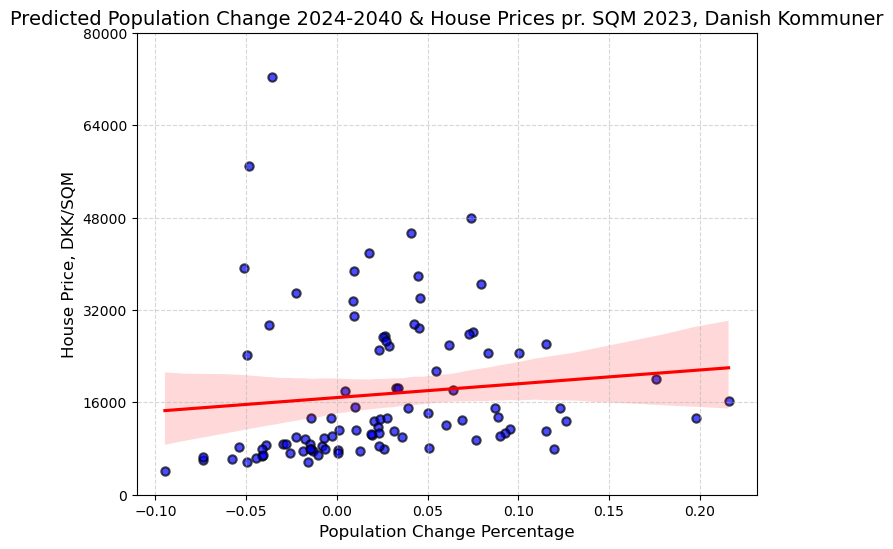

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with blue markers
x = df_pop_house['POP_CHANGE_PERCENT']
y = df_pop_house['SQM PRICE 2023']
sns.regplot(x=x, y=y, color='blue', scatter_kws={'alpha':0.7, 'edgecolors':'black', 'linewidths':1.5},
            line_kws={'color':'red', 'linestyle':'-'}, ax=ax)

# Set labels and title with larger font size
ax.set_xlabel('Population Change Percentage', fontsize=12)
ax.set_ylabel('House Price, DKK/SQM', fontsize=12)
ax.set_title('Predicted Population Change 2024-2040 & House Prices pr. SQM 2023, Danish Kommuner', fontsize=14)

# Replace non-numeric values with NaN (læsø)
df_pop_house['POP_CHANGE_PERCENT'] = pd.to_numeric(df_pop_house['POP_CHANGE_PERCENT'], errors='coerce')
df_pop_house['SQM PRICE 2023'] = pd.to_numeric(df_pop_house['SQM PRICE 2023'], errors='coerce')

# Drop rows with NaN values
df_cleaned = df_pop_house.dropna(subset=['POP_CHANGE_PERCENT', 'SQM PRICE 2023'], how='any')

# Calculate correlation coefficient
correlation = df_cleaned['POP_CHANGE_PERCENT'].corr(df_cleaned['SQM PRICE 2023'])
print(f"Correlation coefficient: {correlation}")

# Set y-axis ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], 6))

# Customize grid appearance
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


There does not seem to be a strong correlation, possibly due to the first mentioned two effects cancelling eachother out. I try dropping out Frederiksberg and Copenhagen, where the price of houses is limited by the small supply of houses, as these kommuner are dominated by flats. These are also, respectively, the most and third-most expensive kommuner (gentofte is nr 2):

In [20]:
# Filter out 'Copenhagen' and 'Frederiksberg'
df_pop_house_filtered = df_pop_house[~df_pop_house['KOMMUNE'].isin(['Copenhagen', 'Frederiksberg'])]

# Display the filtered dataframe
print(df_pop_house_filtered)

          KOMMUNE     POP24     POP40  POP_CHANGE_ABSOLUTE  POP_CHANGE_PERCENT  SQM PRICE 2023
2        Ballerup   51237.0   53552.0               2315.0            0.045182         28911.0
3         Brøndby   39067.0   40186.0               1119.0            0.028643         25721.0
4          Dragør   14569.0   15234.0                665.0            0.045645         34046.0
5        Gentofte   75033.0   71408.0              -3625.0           -0.048312         56948.0
6        Gladsaxe   70600.0   71270.0                670.0            0.009490         38773.0
..            ...       ...       ...                  ...                 ...             ...
92         Rebild   30937.0   33727.0               2790.0            0.090183         10166.0
93  Mariagerfjord   41762.0   41490.0               -272.0           -0.006513          7840.0
94     Jammerbugt   38234.0   37675.0               -559.0           -0.014620          7956.0
95        Aalborg  223174.0  242661.0             

A second analysis shows the correlation coefficent has now risen!

Correlation coefficient: 0.1592839131328915


/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/740720718.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered['POP_CHANGE_PERCENT'] = pd.to_numeric(df_pop_house_filtered['POP_CHANGE_PERCENT'], errors='coerce')
/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/740720718.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')


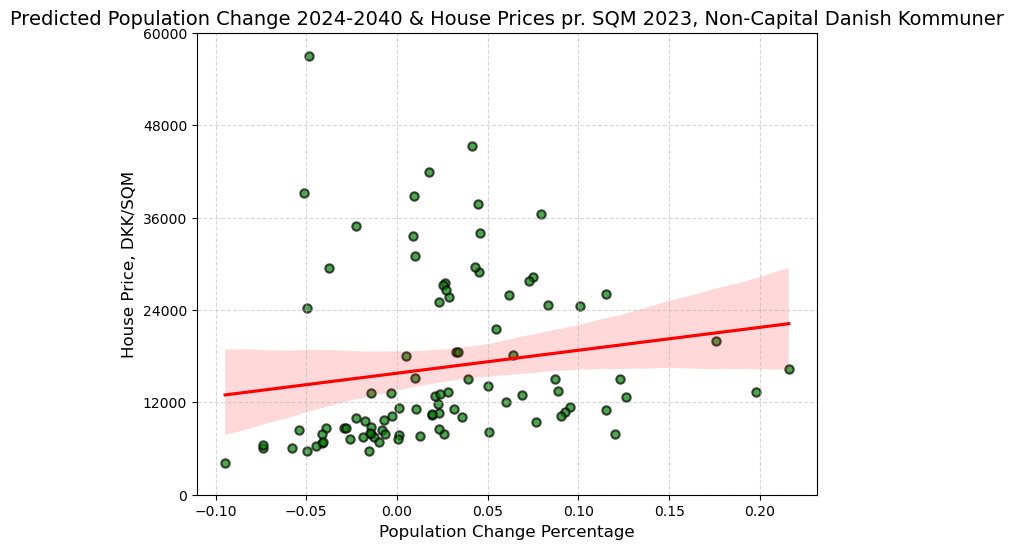

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with blue markers
x = df_pop_house_filtered['POP_CHANGE_PERCENT']
y = df_pop_house_filtered['SQM PRICE 2023']
sns.regplot(x=x, y=y, color='green', scatter_kws={'alpha':0.7, 'edgecolors':'black', 'linewidths':1.5},
            line_kws={'color':'red', 'linestyle':'-'}, ax=ax)

# Set labels and title with larger font size
ax.set_xlabel('Population Change Percentage', fontsize=12)
ax.set_ylabel('House Price, DKK/SQM', fontsize=12)
ax.set_title('Predicted Population Change 2024-2040 & House Prices pr. SQM 2023, Non-Capital Danish Kommuner', fontsize=14)

# Replace non-numeric values with NaN (læsø)
df_pop_house_filtered['POP_CHANGE_PERCENT'] = pd.to_numeric(df_pop_house_filtered['POP_CHANGE_PERCENT'], errors='coerce')
df_pop_house_filtered['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')

# Drop rows with NaN values
df_cleaned = df_pop_house_filtered.dropna(subset=['POP_CHANGE_PERCENT', 'SQM PRICE 2023'], how='any')

# Calculate correlation coefficient
correlation = df_cleaned['POP_CHANGE_PERCENT'].corr(df_cleaned['SQM PRICE 2023'])
print(f"Correlation coefficient: {correlation}")

# Set y-axis ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], 6))

# Customize grid appearance
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


I also research the correlation between house price and absolute population:

Correlation coefficient: 0.2695091056085005


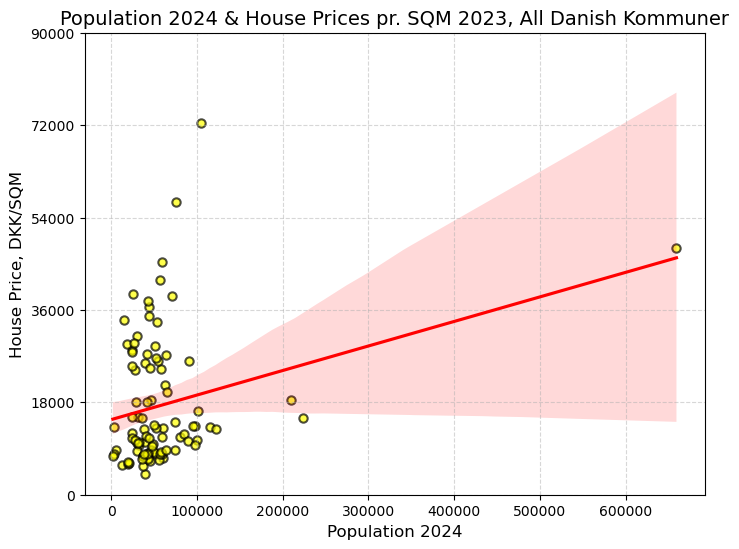

In [22]:
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plot with blue markers
    x = df_pop_house['POP24']  # Change to 'POP24'
    y = df_pop_house['SQM PRICE 2023']
    sns.regplot(x=x, y=y, color='yellow', scatter_kws={'alpha':0.7, 'edgecolors':'black', 'linewidths':1.5},
                line_kws={'color':'red', 'linestyle':'-'}, ax=ax)

    # Set labels and title with larger font size
    ax.set_xlabel('Population 2024', fontsize=12)  # Change label
    ax.set_ylabel('House Price, DKK/SQM', fontsize=12)
    ax.set_title('Population 2024 & House Prices pr. SQM 2023, All Danish Kommuner', fontsize=14)

    # Replace non-numeric values with NaN (læsø)
    df_pop_house['POP24'] = pd.to_numeric(df_pop_house['POP24'], errors='coerce')  # Change column name
    df_pop_house['SQM PRICE 2023'] = pd.to_numeric(df_pop_house['SQM PRICE 2023'], errors='coerce')

    # Drop rows with NaN values
    df_cleaned = df_pop_house.dropna(subset=['POP24', 'SQM PRICE 2023'], how='any')  # Change column name

    # Calculate correlation coefficient
    correlation = df_cleaned['POP24'].corr(df_cleaned['SQM PRICE 2023'])  # Change column name
    print(f"Correlation coefficient: {correlation}")

    # Set y-axis ticks
    ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], 6))

    # Customize grid appearance
    ax.grid(True, linestyle='--', alpha=0.5)

    # Show plot
    plt.show()


We run into an issue with Copenhagen once again, and run our removed data set:

Correlation coefficient: 0.039375594851976024


/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/58445424.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered['POP24'] = pd.to_numeric(df_pop_house_filtered['POP24'], errors='coerce')  # Change column name
/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/58445424.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')


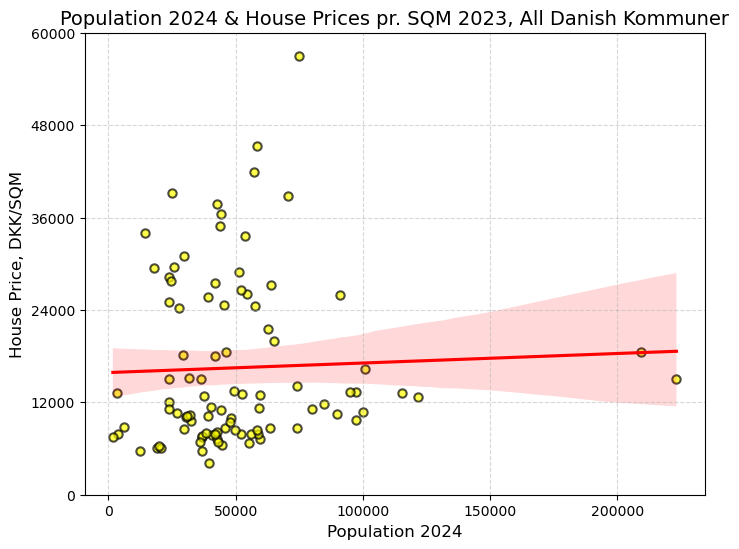

In [23]:


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with blue markers
x = df_pop_house_filtered['POP24']  # Use 'POP24' column from df_pop_house_filtered
y = df_pop_house_filtered['SQM PRICE 2023']
sns.regplot(x=x, y=y, color='yellow', scatter_kws={'alpha':0.7, 'edgecolors':'black', 'linewidths':1.5},
            line_kws={'color':'red', 'linestyle':'-'}, ax=ax)

# Set labels and title with larger font size
ax.set_xlabel('Population 2024', fontsize=12)  # Change label
ax.set_ylabel('House Price, DKK/SQM', fontsize=12)
ax.set_title('Population 2024 & House Prices pr. SQM 2023, All Danish Kommuner', fontsize=14)

# Replace non-numeric values with NaN (læsø)
df_pop_house_filtered['POP24'] = pd.to_numeric(df_pop_house_filtered['POP24'], errors='coerce')  # Change column name
df_pop_house_filtered['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')

# Drop rows with NaN values
df_cleaned = df_pop_house_filtered.dropna(subset=['POP24', 'SQM PRICE 2023'], how='any')  # Change column name

# Calculate correlation coefficient
correlation = df_cleaned['POP24'].corr(df_cleaned['SQM PRICE 2023'])  # Change column name
print(f"Correlation coefficient: {correlation}")

# Set y-axis ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], 6))

# Customize grid appearance
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


Still not quite good enough, we also remove Aarhus, Aalborg, and Odense. This way, we leave out all major urban centres, where house prices are affected by the low availabiltiy of houses, as most people live in flats.

In [24]:
# Filter out sAarhus, Aalborg and Odense
df_pop_house_filtered2 = df_pop_house_filtered[~df_pop_house_filtered['KOMMUNE'].isin(['Aarhus', 'Aalborg','Odense'])]

# Display the filtered dataframe
print(df_pop_house_filtered2)

          KOMMUNE    POP24    POP40  POP_CHANGE_ABSOLUTE  POP_CHANGE_PERCENT  SQM PRICE 2023
2        Ballerup  51237.0  53552.0               2315.0            0.045182         28911.0
3         Brøndby  39067.0  40186.0               1119.0            0.028643         25721.0
4          Dragør  14569.0  15234.0                665.0            0.045645         34046.0
5        Gentofte  75033.0  71408.0              -3625.0           -0.048312         56948.0
6        Gladsaxe  70600.0  71270.0                670.0            0.009490         38773.0
..            ...      ...      ...                  ...                 ...             ...
91           Læsø   1759.0   1726.0                -33.0           -0.018761          7535.0
92         Rebild  30937.0  33727.0               2790.0            0.090183         10166.0
93  Mariagerfjord  41762.0  41490.0               -272.0           -0.006513          7840.0
94     Jammerbugt  38234.0  37675.0               -559.0           -0.

Correlation coefficient: 0.05287217512691958


/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/1500536542.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered2['POP24'] = pd.to_numeric(df_pop_house_filtered['POP24'], errors='coerce')  # Change column name
/var/folders/nm/fjp9cd3x5290m0mm822fzg240000gn/T/ipykernel_13645/1500536542.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_house_filtered2['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')


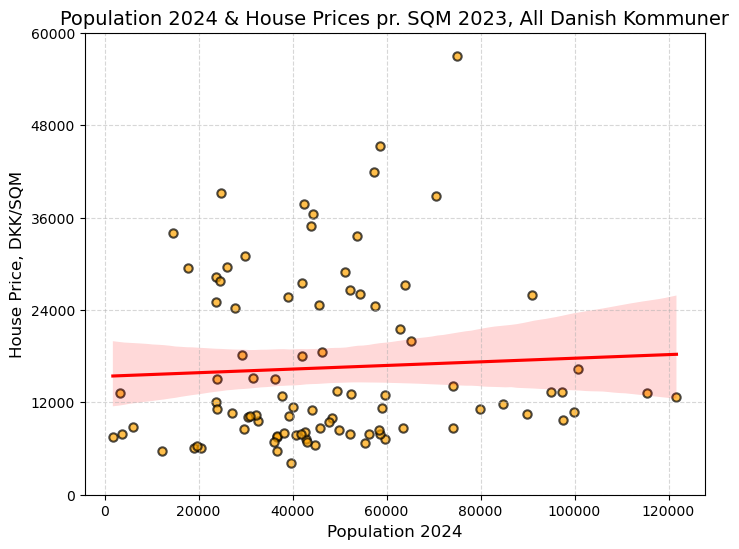

In [25]:


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with blue markers
x = df_pop_house_filtered2['POP24']  # Use 'POP24' column from df_pop_house_filtered
y = df_pop_house_filtered2['SQM PRICE 2023']
sns.regplot(x=x, y=y, color='orange', scatter_kws={'alpha':0.7, 'edgecolors':'black', 'linewidths':1.5},
            line_kws={'color':'red', 'linestyle':'-'}, ax=ax)

# Set labels and title with larger font size
ax.set_xlabel('Population 2024', fontsize=12)  # Change label
ax.set_ylabel('House Price, DKK/SQM', fontsize=12)
ax.set_title('Population 2024 & House Prices pr. SQM 2023, All Danish Kommuner', fontsize=14)

# Replace non-numeric values with NaN (læsø)
df_pop_house_filtered2['POP24'] = pd.to_numeric(df_pop_house_filtered['POP24'], errors='coerce')  # Change column name
df_pop_house_filtered2['SQM PRICE 2023'] = pd.to_numeric(df_pop_house_filtered['SQM PRICE 2023'], errors='coerce')

# Drop rows with NaN values
df_cleaned = df_pop_house_filtered2.dropna(subset=['POP24', 'SQM PRICE 2023'], how='any')  # Change column name

# Calculate correlation coefficient
correlation = df_cleaned['POP24'].corr(df_cleaned['SQM PRICE 2023'])  # Change column name
print(f"Correlation coefficient: {correlation}")

# Set y-axis ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], 6))

# Customize grid appearance
ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


Sadly, the correlation is still not clear.

# Conclusion



In conclusion, there seems to be a somewhat strong positive correlation between current house prices and the expected population growth of a municipality in Denmark. This points to the effect that higher prices reflect a higher demand for the area, which is expected to continue into the future.